In [42]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "tensorflow.compat.v1"
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf"

# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

In [2]:
import tensorflow.compat.v1 as tf

import deepxde as dde
import numpy as np
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pylab
from numpy import linalg as LA
import math
import scipy.io
from os.path import dirname, join as pjoin
from scipy.stats import truncnorm, norm
# import tensorflow as tf
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    
if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2022-09-07 23:11:48.080796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 23:11:48.084906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 23:11:48.085129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [12]:
N = nSample = 100

# must be floats
state_min = 0.0
state_max = 6.0

mu_0 = 5.0
sigma_0 = 1.0

mu_T = 2.0
sigma_T = 0.5

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

print(time.time())

1662617780.3065205


In [9]:
def boundary(_, on_initial):
    return on_initial

def pdf1d_T(x):
    a, b = (state_min - mu_T) / sigma_T, (state_max - mu_T) / sigma_T
    rho_x=truncnorm.pdf(x, a, b, loc = mu_0, scale = sigma_0)

#     rho_x = norm.pdf(x, mu_T, sigma_T)
    return rho_x

def pdf1d_0(x):
    a, b = (state_min - mu_0) / sigma_0, (state_max - mu_0) / sigma_0
    rho_x=truncnorm.pdf(x, a, b, loc = mu_0, scale = sigma_0)

#     rho_x = norm.pdf(x, mu_0, sigma_0)
    return rho_x

print(time.time())

1662617743.537177


In [ ]:
rv0 = multivariate_normal([mu_0, mu_0, mu_0], sigma_0 * np.eye(3))
rvT = multivariate_normal([mu_T, mu_T, mu_T], sigma_T * np.eye(3))

def pdf3d_0(x,y,z):
    return rv0.pdf(np.hstack((x, y, z)))

def pdf3d_T(x,y,z):
    return rvT.pdf(np.hstack((x, y, z)))

print(time.time())

In [10]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)
print(time.time())

1662617747.600795


In [13]:
# 3d linprog example, with bounds

rho_0=pdf3d_0(x_T,y_T,z_T).reshape(len(x_T),1)
rho_T=pdf3d_T(x_T,y_T,z_T).reshape(len(x_T),1)

# very important to make it solvable
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(rho_0)

rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(rho_T)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print(np.sqrt(res.fun))

NameError: name 'pdf3d_0' is not defined

In [14]:
# 1d linprog example

rho_0_1d=pdf1d_0(x_T).reshape(len(x_T),1)
rho_T_1d=pdf1d_T(x_T).reshape(len(x_T),1)

rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)
rho_0_1d = rho_0_1d / np.sum(np.abs(rho_0_1d))

# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)[0]
# rho_0_1d = rho_0_1d / rho_0_1d_trapz
# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)
# print("rho_0_1d_trapz=",rho_0_1d_trapz)

print(rho_0_1d)

rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)

rho_T_1d = rho_T_1d / np.sum(np.abs(rho_T_1d))

# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)[0]
# rho_T_1d = rho_T_1d / rho_T_1d_trapz
# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)
# print("rho_T_1d_trapz=",rho_T_1d_trapz)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0_1d, rho_T_1d), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print(np.sqrt(res.fun))

[[0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.001]
 [0.002]
 [0.002]
 [0.002]
 [0.002]
 [0.003]
 [0.003]
 [0.004]
 [0.004]
 [0.005]
 [0.005]
 [0.006]
 [0.006]
 [0.007]
 [0.008]
 [0.009]
 [0.009]
 [0.01 ]
 [0.011]
 [0.012]
 [0.013]
 [0.014]
 [0.015]
 [0.016]
 [0.017]
 [0.018]
 [0.019]
 [0.02 ]
 [0.021]
 [0.022]
 [0.023]
 [0.024]
 [0.025]
 [0.026]
 [0.026]
 [0.027]
 [0.027]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.028]
 [0.027]
 [0.027]
 [0.026]
 [0.026]
 [0.025]
 [0.024]
 [0.023]
 [0.022]
 [0.021]
 [0.02 ]
 [0.019]
 [0.018]
 [0.017]]
Running HiGHS 1.2.2 [date: 2022-08-30, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licenc

In [ ]:
# def modify_output(X, Y):
#     y1, y2, y3  = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3]
#     u_new = tf.clip_by_value(y3, clip_value_min = .5, clip_value_max = 4)
#     return tf.concat((y1, y2, u_new), axis=1)

In [15]:
S3 = dde.Variable(1.0)
a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005
K, T=1.38066*10**-23, 293.

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here
    Including a penalty function for negative solutions
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
#     dD2_x=dde.grad.jacobian(D2, x, j=0)
#     dF_x=dde.grad.jacobian(F, x, j=0)
#     D1=dD2_x-dF_x*(D2/(K*T))
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100

    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
#         neg_loss,
#         neg_loss_y2,
    ]


print(time.time())

1662617812.5813775


In [31]:
def penalty(y_pred):
    p1 = 10 * (y_pred<0).sum()
    
    t = np.trapz(y_pred, axis=0)[0]
    p2 = 10 * np.abs(t - 1)
    return p1 + p2

def WASS(y_true, y_pred):
    xpdf = y_pred.numpy()
    
#     print(xpdf.shape)

    xpdf = np.where(xpdf < 0, 0, xpdf)
    if np.sum(xpdf) > 1e-8:
        xpdf = xpdf / np.sum(xpdf)

    res = linprog(
        cvector,
        A_eq=A,
        b_eq=np.concatenate((xpdf, rho_0_1d), axis=0),
        options={"disp": False},
        bounds=[(0, np.inf)],
    )
    
    # we are cheating here, we are using tf.reduce_sum
    # so that tf system will like our output 'type'
    # but we are 0'ing the sum and adding our scalar cost
    cand = tf.reduce_sum(y_pred) * 0.0
    
    if res.fun is None:
        return np.inf + cand
    else:
        return np.sqrt(res.fun) + cand + penalty(xpdf)

def WASS2(y_true, y_pred):
    loss = tf.py_function(
        func=WASS,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

print(time.time())

1662618414.2125614


In [32]:
geom = dde.geometry.Interval(state_min, state_max)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

print(time.time())

1662618419.553854


In [33]:
time_0=np.hstack((x_T,T_0*np.ones((len(x_T), 1))))
rho_0=pdf1d_0(x_T).reshape(len(x_T),1)
rho_0_BC = dde.icbc.PointSetBC(time_0, rho_0, component=1)

time_t=np.hstack((x_T,T_t*np.ones((len(x_T), 1))))
rho_T=pdf1d_T(x_T).reshape(len(x_T),1)
rho_T_BC = dde.icbc.PointSetBC(time_t, rho_T, component=1)

print(time.time())

1662618420.0395167


In [34]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [rho_0_BC,rho_T_BC],
    num_domain=5000,
    num_initial=500)
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
# net.apply_output_transform(modify_output)
# net.apply_output_transform(modify_output)
model = dde.Model(data, net)

print(time.time())

1662618420.6333845


In [35]:
ck_path = "%s/model" % (os.path.abspath("./"))

class EarlyStoppingFixed(dde.callbacks.EarlyStopping):
    def on_epoch_end(self):
        current = self.get_monitor_value()
        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            # must meet baseline first
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = self.model.train_state.epoch
                self.model.stop_training = True
        else:
            self.wait = 0
                
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch))
        
        self.model.save(ck_path, verbose=True)

earlystop_cb = EarlyStoppingFixed(baseline=1e-3, patience=0)

In [37]:
loss_func=["MSE","MSE","MSE", WASS2,"MSE"]
model.compile("adam", lr=1e-3,loss=loss_func)
losshistory, train_state = model.train(
    epochs=30000,
    display_every=1000,
    callbacks=[earlystop_cb])

Compiling model...
Tensor("Sum_45:0", shape=(), dtype=float32)
Tensor("Sum_46:0", shape=(), dtype=float32)
Tensor("Sum_47:0", shape=(), dtype=float32)
Tensor("Sum_48:0", shape=(), dtype=float32)
Tensor("Sum_49:0", shape=(), dtype=float32)
Tensor("Sum_50:0", shape=(), dtype=float32)
Tensor("Sum_51:0", shape=(), dtype=float32)
Tensor("Sum_52:0", shape=(), dtype=float32)
'compile' took 1.632612 s

Training model...



2022-09-07 23:38:13.937980: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2022-09-07 23:38:13.957286: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


Step      Train loss                                            Test loss                                             Test metric
15000     [2.59e-08, 9.50e-06, 6.84e-08, inf, 6.06e-07]         [2.59e-08, 9.50e-06, 6.84e-08, inf, 6.06e-07]         []  


2022-09-07 23:38:14.234129: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2022-09-07 23:38:14.253370: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2022-09-07 23:38:14.967734: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:UNIMPLEMENTED: Could not find compiler for platform CUDA: NOT_FOUND: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as 

16000     [2.28e-08, 7.51e-06, 3.97e-08, inf, 4.52e-07]         [2.28e-08, 7.51e-06, 3.97e-08, inf, 4.52e-07]         []  
17000     [3.80e-08, 1.09e-05, 3.88e-08, 7.49e+00, 1.61e-05]    [3.80e-08, 1.09e-05, 3.88e-08, 7.49e+00, 1.61e-05]    []  
18000     [2.12e-08, 5.90e-06, 4.33e-09, 7.36e+00, 3.43e-07]    [2.12e-08, 5.90e-06, 4.33e-09, 7.36e+00, 3.43e-07]    []  
19000     [2.32e-08, 5.23e-06, 3.03e-09, 7.02e+00, 3.39e-06]    [2.32e-08, 5.23e-06, 3.03e-09, 7.02e+00, 3.39e-06]    []  
20000     [1.26e-08, 4.36e-06, 2.81e-09, 7.50e+00, 2.62e-07]    [1.26e-08, 4.36e-06, 2.81e-09, 7.50e+00, 2.62e-07]    []  
21000     [2.00e-08, 3.76e-06, 2.09e-09, 6.00e+00, 1.46e-04]    [2.00e-08, 3.76e-06, 2.09e-09, 6.00e+00, 1.46e-04]    []  
22000     [1.20e-08, 4.09e-06, 1.19e-09, 7.71e+00, 3.51e-07]    [1.20e-08, 4.09e-06, 1.19e-09, 7.71e+00, 3.51e-07]    []  
23000     [1.21e-08, 4.40e-06, 8.88e-10, 8.04e+00, 3.36e-07]    [1.21e-08, 4.40e-06, 8.88e-10, 8.04e+00, 3.36e-07]    []  
24000     [2.57e

Saving loss history to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/loss.dat ...
Saving training data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/train.dat ...
Saving test data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/test.dat ...


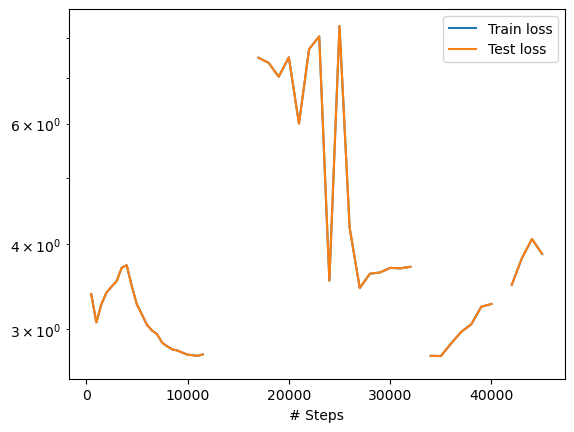

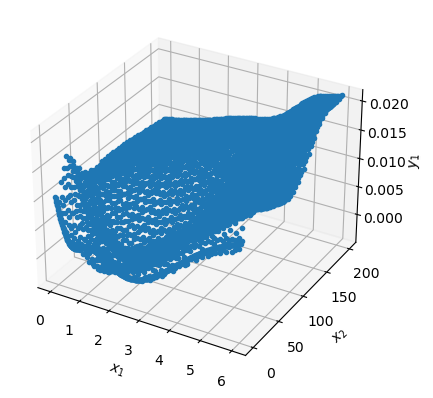

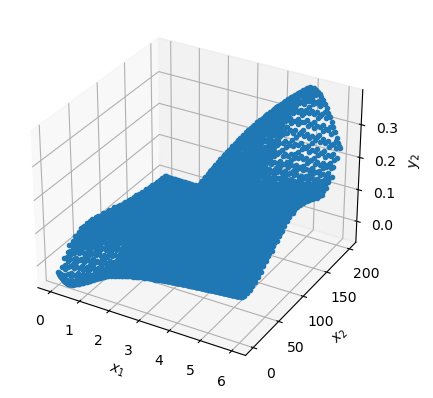

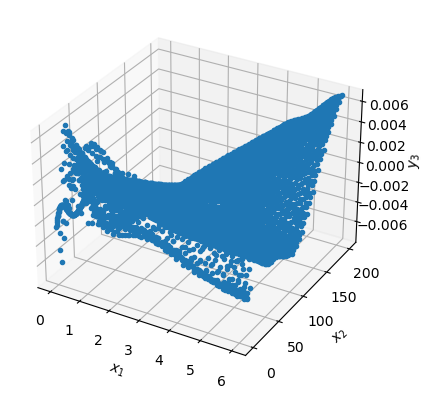

In [38]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
model_path = model.save(ck_path)
print(model_path)

In [39]:
params = {'backend': 'ps',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.handlelength': 1,
          'legend.borderaxespad': 0,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
plt.style.use('seaborn-white')

loss_loaded [[    0.        0.013     0.001     0.199       inf     0.042     0.013     0.001     0.199       inf     0.042]
 [  500.        0.        0.        0.        3.377     0.003     0.        0.        0.        3.377     0.003]
 [ 1000.        0.        0.        0.        3.071     0.002     0.        0.        0.        3.071     0.002]
 [ 1500.        0.        0.        0.        3.265     0.        0.        0.        0.        3.265     0.   ]
 [ 2000.        0.        0.        0.        3.396     0.        0.        0.        0.        3.396     0.   ]
 [ 2500.        0.        0.        0.        3.465     0.        0.        0.        0.        3.465     0.   ]
 [ 3000.        0.        0.        0.        3.528     0.        0.        0.        0.        3.528     0.   ]
 [ 3500.        0.        0.        0.003     3.689     0.        0.        0.        0.003     3.689     0.   ]
 [ 4000.        0.        0.        0.        3.724     0.        0.        0.      

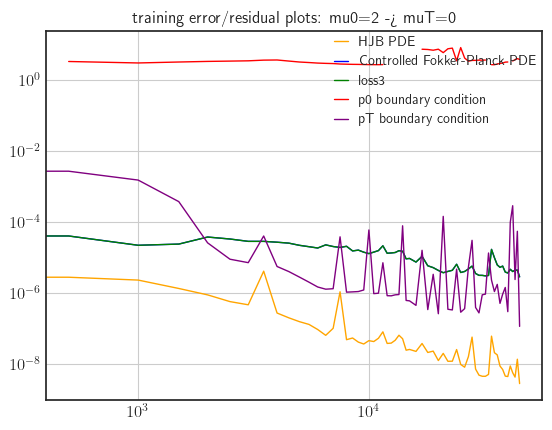

In [40]:
# 16 plot loss

loss_loaded = np.genfromtxt('./loss.dat')

print("loss_loaded", loss_loaded)

# import ipdb; ipdb.set_trace();

# [0] epoch
# [1] y1, psi, hjb
# [2] y2, rho, plank pde
# [3] rho0, initial
# [4] rhoT, terminal

epoch = loss_loaded[:, 0]
y1_psi_hjb = loss_loaded[:, 1]
y2_rho_plankpde = loss_loaded[:, 2]
loss3 = loss_loaded[:, 3]
rho0_initial = loss_loaded[:, 4]
rhoT_terminal = loss_loaded[:, 5]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')

line1, = ax.plot(epoch, y1_psi_hjb, color='orange', lw=1, label='HJB PDE')
line2, = ax.plot(epoch, y2_rho_plankpde, color='blue', lw=1, label='Controlled Fokker-Planck PDE')
line2, = ax.plot(epoch, y2_rho_plankpde, color='green', lw=1, label='loss3')
line3, = ax.plot(epoch, rho0_initial, color='red', lw=1, label='p0 boundary condition')
line4, = ax.plot(epoch, rhoT_terminal, color='purple', lw=1, label='pT boundary condition')

ax.grid()
ax.legend(loc="upper right")
ax.set_title('training error/residual plots: mu0=2 -> muT=0')
ax.set_yscale('log')
ax.set_xscale('log')

plot_fname = "%s/loss.png" % (os.path.abspath("./"))
plt.savefig(plot_fname, dpi=300)
print("saved plot")

plt.show()

In [41]:
# 18 load test data

test = np.genfromtxt('./test.dat')
# test_timesorted = test[test[:, 3].argsort()]
# sort AGAIN by output because a lot of samples @ t=0, t=5
ind = np.lexsort((test[:,2],test[:,1])) # sorts by [3] (t) then by [4] (psi)
test_timesorted = test[ind]
source_t = test_timesorted[:, 1]

print(test_timesorted)

[[  2.438   0.      0.      0.036   0.003]
 [  2.426   0.      0.      0.036   0.003]
 [  2.424   0.      0.      0.036   0.003]
 ...
 [  5.879 200.      0.021   0.266   0.007]
 [  5.939 200.      0.021   0.252   0.007]
 [  6.    200.      0.021   0.238   0.007]]


In [ ]:
# 35 plot rho at t=5, t=0

target_t = 0.0

N = 100

test_timesorted = test[test[:, 1].argsort()]
timesorted = test_timesorted[:, 1]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

ti_rho_opt = test_ti[:, 5]

ti_rho_opt = np.where(ti_rho_opt<0, 0, ti_rho_opt)

ti_x1_x2_x3 = test_ti[:, 0:3]

####################################################################

d = 0.0
x1 = np.linspace(state_min - d, state_max + d, N)
x2 = np.linspace(state_min - d, state_max + d, N)
x3 = np.linspace(state_min - d, state_max + d, N)
X1, X2, X3 = np.meshgrid(x1,x2,x3,copy=False) # each is NxNxN

rho_opt = np.zeros((N,N,N))

closest_1 = [(np.abs(x1 - ti_x1_x2_x3[i, 0])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_2 = [(np.abs(x2 - ti_x1_x2_x3[i, 1])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_3 = [(np.abs(x3 - ti_x1_x2_x3[i, 2])).argmin() for i in range(ti_x1_x2_x3.shape[0])]

# some transposing going on in some reshape
# swapping closest_1/2 works well
rho_opt[closest_1, closest_2, closest_3] = ti_rho_opt

####################################################################

# RHO_OPT = gd(
#   (ti_x1_x2_x3[:, 0], ti_x1_x2_x3[:, 1], ti_x1_x2_x3[:, 2]),
#   ti_rho_opt,
#   (X1, X2, X3),
#   method='linear')

####################################################################

x1_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[j, i, :], x=x3) # x3 slices for one x2 => R
            for i in range(len(x2))]) # x3 slices across all x2 => Rn
        , x=x2) # x2 slice for one x1 => R
for j in range(len(x1))])

x2_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, j, :], x=x3) # x3 slices for one x1 => R
            for i in range(len(x1))]) # x3 slices across all x1 => Rn
        , x=x1) # x1 slice for one x2 => R
for j in range(len(x2))])

x3_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, :, j], x=x2) # x2 slices for one x1 => R
            for i in range(len(x1))]) # x2 slices across all x1 => Rn
        , x=x1) # x1 slice for one x3 => R
for j in range(len(x3))])

####################################################################

# normalize all the pdfs so area under curve ~= 1.0
x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("prior to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

x1_marginal /= x1_pdf_area
x2_marginal /= x2_pdf_area
x3_marginal /= x3_pdf_area

print(x1_marginal.shape)

x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("after to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

fig = plt.figure(1)
ax1 = plt.subplot(131, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('x1 marginal')

ax2 = plt.subplot(132, frameon=False)
# ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('x2 marginal')

# ax3 = plt.subplot(133, frameon=False)

ax3 = plt.subplot(133, frameon=False)
# ax3.set_aspect('equal')
ax3.grid()
ax3.set_title('x3 marginal')

colors="rgbymkc"

i = 0
t_e = 0
ax1.plot(x1,
    x1_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax1.legend(loc='lower right')

ax2.plot(x2,
    x2_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax2.legend(loc='lower right')

ax3.plot(x3,
    x3_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax3.legend(loc='lower right')

fig.suptitle('t=%.2f' % (target_t), fontsize=16)

plt.show()